In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [82]:
%cd /content/drive/MyDrive/Voice_Phishing_Detector

[Errno 2] No such file or directory: '/content/drive/MyDrive/Voice_Phishing_Detector'
/Users/kimhyeongjun/junjun/github_develop/Voice-Phishing-Detector/Mecab-ko-for-Google-Colab


In [ ]:
!nvidia-smi

In [51]:
!pip install python-dotenv
!pip install openai google-cloud-speech
!pip install transformer
!pip install konlpy

In [47]:
import os
import re
import numpy as np
import pandas as pd
import dotenv
from openai import OpenAI
from tqdm import tqdm 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import BertTokenizerFast, BertConfig, BertModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter

# 토크나이저 관련 경고 무시하기 위하여 설정
os.environ["TOKENIZERS_PARALLELISM"] = 'true'

# # device 지정
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f'사용 디바이스: {device}')


사용 디바이스: mps


In [2]:
# df = pd.read_csv('dataset/KorCCVi_v2.1.csv').sample(frac=1.0)
df = pd.read_csv('dataset/combined_dataset.csv').sample(frac=1.0)
df.isnull().sum()

num           0
transcript    1
label         0
dtype: int64

In [3]:
print(Counter(df['label'])[1])
print(Counter(df['label'])[0])
print(df.count())
print(df.sample(n=5))

695
6106
num           6801
transcript    6800
label         6801
dtype: int64
       num                                         transcript  label
4256  4257  수신거래 골드플러스 이상 고객인데 인터넷 전자서명대출 대상고객이 안되나요?\n네, ...      0
4784  4785  이상형이 뭐야? 외적 이상형이랑 내적 이상형이 다르게 있는데 외적은 나보다는 키가 ...      0
671    672  지하철 전문배송 업체구요 그리고 물론 자체는 무거운게 아니고 법원에서 공탁서류 부동...      1
2765  2766  OO은행에서는 마이너스 통장 상품이 있습니까?\n예, 마이너스 통장 상품이 있습니다...      0
1112  1113  약관대출을 받고 싶은데요.\n네, 홈페이지 또는 저희 보험사 앱을 통한 대출이 가능...      0


In [4]:
# df = df.drop(['num'], axis=1, inplace=False)
df = df.drop(['num'], axis=1, inplace=False)
df['transcript'] = df['transcript'].astype('string')
print(df.head())
first_column = df.pop('label')
df.insert(0, 'label', first_column)
df.rename(columns = {'label':'Label', 'transcript':'Text'}, inplace = True)
df.sample(n=5)

                                             transcript  label
6422  혹시 너는 영화 주제 중에 주제나 장르 중에 좋아하는 그런 게 있어? 나는 영화 장...      0
4464  인터넷뱅킹으로 이체했던 입금계좌번호를 알 수 있나요?
네.가능합니다.
어떻게 하면 ...      0
4121  ATM기기에서 현금 출금을 하고 싶습니다
통장에 있는 돈을 좀 빼고 싶은데 기기에서...      0
480   찜질방 차리면서 본인에게 연락을 드린 정확한 이유는요? 불법 현장에서 본인 명의로 ...      1
2129  네 있습니다
얼마에요?
수수료는 이천원 입니다
OTP카드 제가 있는거 같은데요?
같...      0


,Label,Text
2305,0,신용대출이 얼마나 가능한가 해서요 본인확인하고 안내해 드리겠습니다. 한도 조회를 위...
2785,0,아파트관리비 자동이체 해지는 어떻게 해야 하나요? 아파트관리비 자동이체 해지는 영업...
6732,0,저는 음식 맛집 요리사 요리법 중에 되게 좋아하는데 음식 같은 거를 최근에 많이 좋...
1455,0,카카오로 자동이체도 되나요? OO은행로 자동이체도 설정할 수 있나요? 네 설정할 수...
580,1,"10월 달부터 현재까지, 지금까지 수천 만 원의 불법 자금이 돈세탁이 되서 해외로 ..."


##결측값 제거

In [5]:
voice_df = df
voice_df = voice_df.dropna()
print(voice_df.count())
print(Counter(voice_df['Label'])[1])
voice_df.isna().sum()

Label    6800
Text     6800
dtype: int64
695


Label    0
Text     0
dtype: int64

## Data preprocessing

### 불용어 제거

In [6]:
stopwords = pd.read_csv('dataset/stopword.txt', header = None)
stopwords.columns = ['word']

stop_list = list(stopwords['word'])
print(stop_list)

['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라', '의해', '을', '를', '에', '의', '가', '으로', '로', '에게', '뿐이다', '의거하여', '근거하여', '입각하여', '기준으로', '예하면', '예를 들면', '예를 들자면', '저', '소인', '소생', '저희', '지말고', '하지마', '하지마라', '다른', '물론', '또한', '그리고', '비길수 없다', '해서는 안된다', '뿐만 아니라', '만이 아니다', '만은 아니다', '막론하고', '관계없이', '그치지 않다', '그러나', '그런데', '하지만', '든간에', '논하지 않다', '따지지 않다', '설사', '비록', '더라도', '아니면', '만 못하다', '하는 편이 낫다', '불문하고', '향하여', '향해서', '향하다', '쪽으로', '틈타', '이용하여', '타다', '오르다', '제외하고', '이 외에', '이 밖에', '하여야', '비로소', '한다면 몰라도', '외에도', '이곳', '여기', '부터', '기점으로', '따라서', '할 생각이다', '하려고하다', '이리하여', '그리하여', '그렇게 함으로써', '하지만', '일때', '할때', '앞에서', '중에서', '보는데서', '으로써', '로써', '까지', '해야한다', '일것이다', '반드시', '할줄알다', '할수있다', '할수있어', '임에 틀림없다', '한다면', '등', '등등', '제', '겨우', '단지', '다만', '할뿐', '딩동', '댕그', '대해서', '대하여', '대하면', '훨씬', '얼마나', '얼마만큼', '얼마큼', '남짓', '여', '얼마간', '약간', '다소', '좀', '조금', '다수', '몇', '얼마', '지만', '하물며', '또한', '그러나', '그렇지만', '하지만', '이외에도', '대해 말하자면', '뿐이다', '다음에', '반대로', '반대로 말하자면', '이와 반대로',

In [8]:
voice_df['Text'] = voice_df['Text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
print(voice_df.sample(n=10))
voice_df['tokenized'] = voice_df['Text'].apply(lambda x: x.split(" "))
print(voice_df.sample(n=10))
voice_df['tokenized'] = voice_df['tokenized'].apply(lambda x: [item for item in x if item not in stop_list])
print(voice_df.sample(10))

      Label                                               Text
5755      0  지난 2018년도에 브라질에서 새로운 대통령을 선거를 했었는데 그 결과 이제 브라질...
1291      0  담보대출 한도를 알고 싶은데요?
담보가 아파트 이신가요?
임야도 담보로 할 수 있나...
1800      0  ATM기기에서 돈이 덜나왔는데 어찌하나요
아, 그러신가요
방법이 없을까요
근처 지점...
3438      0  대출을 받아서 단독주택을 짓고 싶은데 가능할까요?
네, 가능합니다.
담보대출로 하고...
3025      0  대출금 상환을 다 하고싶은데, 인터넷이 안되요. 다른 방법이 있나요?
네, 당사 A...
4475      0  ATM기에서 이체가 가능해요?
네. 통장 출금 서비스를 신청하면 가능하십니다.
신청...
1115      0  제가 보험계약대출을 얼마받았는지 알수있나요?
어플설치하시고 공인인증서 로그인하시면 ...
1846      0  네 같이 조회 하실 수 있습니다
대출 금리 문의 드립니다
금리에는 어떤것들이 있나요...
4473      0  이체한도 좀 조정해주세요
네. 이체한도 하향조정은 인터넷뱅킹에서 가능합니다.
네, ...
4595      0  지금 이루고 싶은 목표 있으신가요? 너무 많죠. 음 저희 아저씨가 우리 우리 옆집이...


/var/folders/sm/m19qm2pd3t92j1bh9ktywm0w0000gn/T/ipykernel_7243/533459056.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  voice_df['Text'] = voice_df['Text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
/var/folders/sm/m19qm2pd3t92j1bh9ktywm0w0000gn/T/ipykernel_7243/533459056.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  voice_df['tokenized'] = voice_df['Text'].apply(lambda x: x.split(" "))


      Label                                               Text  \
1323      0  안녕하세요. 대출 관련해서 문의드려도 될까요?
청년대출은 나이제한이 있나요?
네 만...   
5689      0  안녕하세요? 저는 프로야구를 굉장히 좋아합니다. 그~ 프로야구가 탄생한 것은 내가 ...   
1894      0  대출금 상환일이 아닌데 상환하려고요?
네
상환일이 아니어도 상환할 수 있나요?
언제...   
6789      0  나는 살면서 가장 많이 본 영화가 라라랜드야. 인생 영화기도 하고 맨 처음에는 되게...   
4759      0  네 제가 최근에 그~ 오메가 쓰리라는 영양제가 에~ 조금 유명하잖아요. 전국적으로 ...   
3308      0  아파트 대출 상환방법에서 매년 균등 분할 상환은 무엇을 말하나요?
네. 이자만 내시...   
560       1  연루된 사건이 있어서 몇 가지 확인 차 연락 드렸습니다. 이모님께서 기모처리라고 아...   
4617      0  어~ 형이 제일 좋 어~ 재밌게 봤던 영화나 인상 깊었던 영화가 있어? 나는 제일 ...   
6417      0  우리가 항상 살면서 건강하다는 보장은 없잖아요. 그래서 요즘 세대 들어오면서부터 치...   
242       1  음. 알겠습니다. 일단은 제가 사건 내용에 대해서 전달을 좀 드릴게요. XXX씨 혹...   

                                              tokenized  
1323  [안녕하세요., 대출, 관련해서, 문의드려도, 될까요?\n청년대출은, 나이제한이, ...  
5689  [안녕하세요?, 저는, 프로야구를, 굉장히, 좋아합니다., 그~, 프로야구가, 탄생...  
1894  [대출금, 상환일이, 아닌데, 상환하려고요?\n네\n상환일이, 아니어도, 상환할, ...  
6789  [나는, 살면서, 가장, 많이, 본, 영화가, 라라랜드야., 인

/var/folders/sm/m19qm2pd3t92j1bh9ktywm0w0000gn/T/ipykernel_7243/533459056.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  voice_df['tokenized'] = voice_df['tokenized'].apply(lambda x: [item for item in x if item not in stop_list])


In [9]:
print(type(voice_df['tokenized'][0]))
print(type(voice_df['Text'][0]))

<class 'list'>
<class 'str'>


In [10]:
voice_df = voice_df.drop(['tokenized'], axis=1, inplace=False)
print(voice_df.sample(n=5))

      Label                                               Text
4740      0   님은 본인의 성격이 어떻다고 생각하시나요? 요즘은 예전과는 다르게 좀 많이 변했다...
4140      0  자동이체 관련 연락드립니다.?
이체-자동이체-설정에서 하시면 됩니다.?
감사합니다....
5278      0  어~ 혹시 어느 학교 어느 학과 다니고 계신지 알 수 있을까요? 저는 단국대학교 도...
6077      0  어~ 혹시 결혼을 하셨으면 현재 가족 관계나 아니면 안 하셨으면 뭐 형제자매 그런 ...
832       0  반갑습니다. OOO대학교 OOO입니다. OO은행의 이체 프로세스를 알려주실 수 있나...


## Data Split

In [12]:

train_data, test_data = train_test_split(voice_df, test_size = 0.2, random_state=40, shuffle=True)

In [13]:
print(train_data.count(), train_data.columns)
print(Counter(train_data['Label'])[1], Counter(train_data['Label'])[0])
print(Counter(test_data['Label'])[1], Counter(test_data['Label'])[0])
print(test_data.count(), test_data.columns)

Label    5440
Text     5440
dtype: int64 Index(['Label', 'Text'], dtype='object')
543 4897
152 1208
Label    1360
Text     1360
dtype: int64 Index(['Label', 'Text'], dtype='object')


In [14]:
print('훈련용 리뷰의 개수 :', len(train_data))
print(train_data.groupby('Label').size().reset_index(name = 'count'))
print('성능측정용 리뷰의 개수 :', len(test_data))
print(test_data.groupby('Label').size().reset_index(name = 'count'))

훈련용 리뷰의 개수 : 5440
   Label  count
0      0   4897
1      1    543
성능측정용 리뷰의 개수 : 1360
   Label  count
0      0   1208
1      1    152


<Axes: xlabel='Label'>

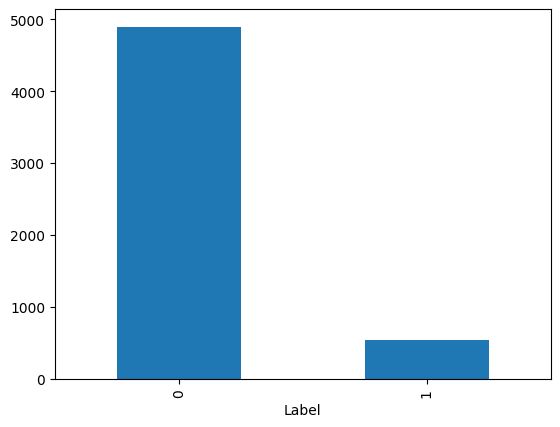

In [15]:
train_data['Label'].value_counts().plot(kind = 'bar')

<Axes: xlabel='Label'>

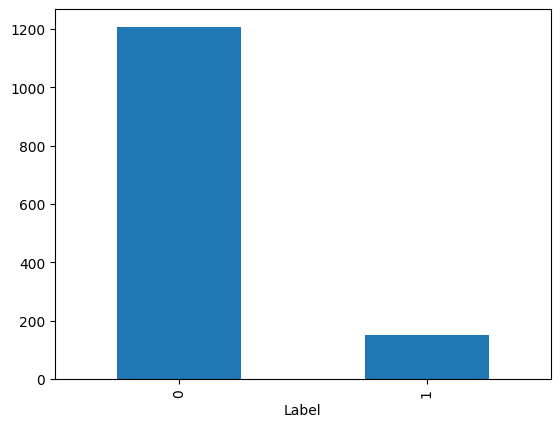

In [16]:
test_data['Label'].value_counts().plot(kind = 'bar')

## KoBERT Tokenizer and Model 

In [17]:
# Define checkpoint and hyperparameters
checkpoint_name = 'kykim/bert-kor-base'
model_name = "bert-kor-base"
batch_size = 16 # 32, 64, 128
num_epochs = 2
learning_rate = 1e-5    #2e-5, 5e-5, 4e-5, 3e-5

In [18]:
# 데이터셋 정의
class TokenDataset(Dataset):
    def __init__(self, dataframe, tokenizer_pretrained):
        self.data = dataframe
        self.tokenizer = BertTokenizerFast.from_pretrained(tokenizer_pretrained)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['Text']
        label = self.data.iloc[idx]['Label']

        tokens = self.tokenizer(
            text,
            return_tensors='pt',     # 텐서 반환
            truncation=True,         # 잘라내기
            padding='max_length',    # 패딩
            add_special_tokens=True  # 스페셜 토큰
        )

        input_ids = tokens['input_ids'].squeeze(0)
        attention_mask = tokens['attention_mask'].squeeze(0)
        token_type_ids = torch.zeros_like(attention_mask)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'token_type_ids': token_type_ids,
        }, torch.tensor(label)

# 토크나이저 지정
tokenizer_pretrained = checkpoint_name

# train, test 데이터셋 생성
train_data = TokenDataset(train_data, tokenizer_pretrained)
test_data = TokenDataset(test_data, tokenizer_pretrained)
train_loader = DataLoader(train_data, batch_size=8, shuffle=True, num_workers=0)
test_loader = DataLoader(test_data, batch_size=8, shuffle=True, num_workers=0)

In [19]:
inputs, labels = next(iter(train_loader))
inputs = {k: v.to(device) for k, v in inputs.items()}
labels.to(device)

tensor([0, 0, 1, 0, 0, 1, 1, 0], device='mps:0')

In [20]:
# 생성된 inputs의 key 값 출력
print(inputs.keys())
inputs['input_ids'].shape, inputs['attention_mask'].shape, inputs['token_type_ids'].shape

dict_keys(['input_ids', 'attention_mask', 'token_type_ids'])


(torch.Size([8, 512]), torch.Size([8, 512]), torch.Size([8, 512]))

In [21]:
config = BertConfig.from_pretrained(checkpoint_name)
model_bert = BertModel.from_pretrained(checkpoint_name).to(device)
print(config)
print(model_bert)

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "embedding_size": 768,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.36.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 42000
}

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(42000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embed

In [22]:
output = model_bert(**inputs)
output.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [23]:
last_hidden_state = output['last_hidden_state']
pooler_output = output['pooler_output']
print(last_hidden_state.shape)
print(last_hidden_state[:, 0, :])
print(pooler_output.shape)
print(pooler_output)

torch.Size([8, 512, 768])
tensor([[-0.2548, -0.5620, -0.2576,  ...,  0.1546,  0.5727, -1.3298],
        [ 0.5352,  0.7036, -1.6586,  ..., -0.1899, -0.9245, -0.1851],
        [-0.3710, -1.0885, -0.6566,  ..., -0.4246, -0.6213, -0.9543],
        ...,
        [ 1.0865,  0.0225,  0.2837,  ..., -1.1161,  0.1551, -0.6981],
        [-0.2230, -0.7909, -1.5858,  ..., -0.0043, -0.1015, -1.0945],
        [-0.5654,  0.0370, -0.0022,  ...,  1.1955,  0.3803, -0.5040]],
       device='mps:0', grad_fn=<SliceBackward0>)
torch.Size([8, 768])
tensor([[-0.0992,  0.2628,  0.1715,  ..., -0.8912, -0.0372, -0.6952],
        [ 0.8240,  0.4737, -0.4955,  ..., -0.9960,  0.2361,  0.1737],
        [ 0.9626,  0.5787, -0.9809,  ..., -0.9493,  0.3895, -0.4923],
        ...,
        [ 0.9588,  0.4940, -0.4010,  ..., -0.9893,  0.0630,  0.6734],
        [ 0.9073,  0.3988, -0.6300,  ..., -0.9940,  0.6251, -0.7504],
        [ 0.1593, -0.0937, -0.2435,  ..., -0.6666,  0.3429, -0.8505]],
       device='mps:0', grad_fn=<Tanh

In [24]:
fc = nn.Linear(768, 2)
fc.to(device)
fc_output = fc(last_hidden_state[:, 0, :])
print(fc_output.shape)
print(fc_output.argmax(dim=1))

torch.Size([8, 2])
tensor([1, 1, 1, 0, 1, 0, 0, 1], device='mps:0')


In [25]:
class CustomBertModel(nn.Module):
    def __init__(self, bert_pretrained, dropout_rate=0.5):
        super(CustomBertModel, self).__init__()
        self.bert = BertModel.from_pretrained(bert_pretrained)
        self.dr = nn.Dropout(p=dropout_rate)
        self.fc = nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        last_hidden_state = output['last_hidden_state']
        x = self.dr(last_hidden_state[:, 0, :])
        x = self.fc(x)
        return x

In [26]:
# CustomBertModel 생성
bert = CustomBertModel(checkpoint_name)
bert.to(device)

CustomBertModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(42000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [27]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(bert.parameters(), lr=learning_rate)

In [28]:
def model_train(model, data_loader, loss_fn, optimizer, device):
    model.train()

    running_loss = 0
    corr = 0
    counts = 0

    prograss_bar = tqdm(data_loader, unit='batch', total=len(data_loader), mininterval=1)
    # mini-batch 학습
    for idx, (inputs, labels) in enumerate(prograss_bar):
        inputs = {k:v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(**inputs)

        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        _, pred = output.max(dim=1)

        corr += pred.eq(labels).sum().item()
        counts += len(labels)
        running_loss += loss.item() * labels.size(0)
        prograss_bar.set_description(f"training loss: {running_loss/(idx+1):.5f}, training accuracy: {corr / counts:.5f}")

    acc = corr / len(data_loader.dataset)
    return running_loss / len(data_loader.dataset), acc

In [29]:
def model_evaluate(model, data_loader, loss_fn, device):
    model.eval()

    with torch.no_grad():
        corr = 0
        running_loss = 0

        for inputs, labels in data_loader:
            inputs = {k:v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)
            output = model(**inputs)
            _, pred = output.max(dim=1)

            corr += torch.sum(pred.eq(labels)).item()
            running_loss += loss_fn(output, labels).item() * labels.size(0)
        acc = corr / len(data_loader.dataset)
        return running_loss / len(data_loader.dataset), acc

In [30]:
min_loss = np.inf

for epoch in range(num_epochs):
    train_loss, train_acc = model_train(bert, train_loader, loss_fn, optimizer, device)
    val_loss, val_acc = model_evaluate(bert, test_loader, loss_fn, device)

    if val_loss < min_loss:
        print(f'[INFO] val_loss has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
        min_loss = val_loss
        torch.save(bert.state_dict(), f'{model_name}.pth')

    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')


training loss: 0.27520, training accuracy: 0.98989: 100%|██████████| 680/680 [10:23<00:00,  1.09batch/s]


[INFO] val_loss has been improved from inf to 0.00416. Saving Model!
epoch 01, loss: 0.03440, acc: 0.98989, val_loss: 0.00416, val_accuracy: 0.99706


training loss: 0.02324, training accuracy: 0.99890: 100%|██████████| 680/680 [10:14<00:00,  1.11batch/s]


[INFO] val_loss has been improved from 0.00416 to 0.00026. Saving Model!
epoch 02, loss: 0.00290, acc: 0.99890, val_loss: 0.00026, val_accuracy: 1.00000


In [34]:
# 저장한 state_dict를 로드 합니다.
model_name = 'bert-kor-base'
bert.load_state_dict(torch.load(f'{model_name}.pth'))

<All keys matched successfully>

In [35]:
class CustomPredictor():
    def __init__(self, model, tokenizer, labels: dict):
        self.model = model
        self.tokenizer = tokenizer
        self.labels = labels

    def predict(self, sentence):
        # 토큰화 처리
        tokens = self.tokenizer(
            sentence,                # 1개 문장
            return_tensors='pt',     # 텐서로 반환
            truncation=True,         # 잘라내기 적용
            padding='max_length',    # 패딩 적용
            add_special_tokens=True  # 스페셜 토큰 적용
        )
        tokens.to(device)
        prediction = self.model(**tokens)
        prediction = F.softmax(prediction, dim=1)
        output = prediction.argmax(dim=1).item()
        prob, result = prediction.max(dim=1)[0].item(), self.labels[output]
        print(f'[{result}]\n확률은: {prob*100:.3f}% 입니다.')
        return [prob*100, result]

In [36]:
# Huggingface 토크나이저 생성
tokenizer = BertTokenizerFast.from_pretrained(checkpoint_name)

labels = {
    0: '일반 대화 입니다.',
    1: '보이스피싱 입니다.'
}

# CustomPredictor 인스턴스를 생성
predictor = CustomPredictor(bert, tokenizer, labels)

In [37]:

def predict_sentence(predictor):
  
    # input_text = "안녕하세요, 어떻게 도와드릴까요? 안녕하세요, 최근에 업무 스트레스 때문에 정말 힘들어요. 네, 이해해요. 어떤 일이 스트레스를 유발하고 있나요? 업무 부하가 매우 많고, 기간 내에 모든 것을 해내기 어려워서 스트레스 받고 있어요. 그런 일들은 정말 어렵겠죠. 어떻게 스트레스 관리를 시도하고 계신가요? 아직은 특별한 방법을 시도하지는 않았어요. 어떻게 관리해야 할지 모르겠어요. 스트레스 관리에 도움이 될 수 있는 몇 가지 방법을 고려해 볼까요? 운동이나 명상을 시도해보는 것도 좋은 방법이 될 수 있어요. 그런 아이디어를 시도해 볼까요. 다른 사람들은 어떻게 스트레스를 관리하나요? 다른 사람들은 다양한 방법을 사용하고 있어요. 일단, 자신에게 가장 적합한 방법을 찾는 것이 중요해요. 또한, 가족이나 친구들과 이야기하고, 지원을 받는 것도 도움이 될 수 있어요." #일반대화(상담)
    # input_text = "여보세요 네 안녕하세요 서울중앙지방검찰청 00부 담당 형사 000입니다. 000님 맞으십니까? 맞는데요 다름이 아니고 혹시 김00님을 아십니까? 지금 김00님이 경남은행에서 000님 명의로 대포통장을 개설하였습니다. 예? 지금 피해사례가 220건이 넘고 대포통장 개설해준 명목으로 000님께서 명의를 도용당하신 것인지, 범죄에 가담한 것인지 확인하려고 전화드렸는데요. 네?? 대포통장이요? 저 그런 적 없는데요 원래는 사건 참고인 조사는 방문조사 하시라고 우편으로 내용을 보내드리는데 긴급한 사항이고 방문하기 어려운 상황이시다 하시면 전화로 조사가 이루어집니다. 그래서 이렇게 유선으로 참고인조사가 이루어지고 있고요. 아 예.. 네 그럼 일단 대포통장 범죄에 000님이 가담하셨는지 아니면 정말 피해자이신건지 몇가지 사항으로 확인드리겠습니다. 괜찮으십니까? 네 그래주세요. 그 전에 본인확인 할텐데요. 녹취가 되고요. 정확하게 진술해주십시요." #보이스피싱 대화
    # input_text = "당신의 계좌가 범죄에 연루되어 있습니다. 피해자 입증을 위해 현금을 인출해서 금감원 직원에게 전달하셔야 합니다." #보이스피싱 대화
    # input_text = "고객님, 1,000만원 대출 받으시고 지정계좌에 송금하시면, 대출기록을 삭제해드릴게요. 그리고 4,600만원까지 대출해드립니다." #보이스피싱 대화
    # input_text = "엄마, 문화상품권을 사러왔는데, 엄마 신용카드랑 주민등록증이 필요하대" #보이스피싱 대화
    # input_text = "여기 OO마트 인데요. 회원님의 카드로 물건을 구매하려는 사람이 있는데 마침 경찰이 와 있으니 경찰 얘기대로 해주세요" #보이스피싱 대화
    # input_text = "OO은행 인데요. 혹시 OOO씨에게 통장과 도장을 맡겨 돈을 찾아오라고 하셨나요? 아니면 경찰을 불러드리겠습니다." #보이스피싱 대화
    # input_text = "고객님의 신상정보가 도용된 카드가 부정 사용되어 연체 중입니다. 경찰에 수사 의뢰를 해드릴테니 전화가 오면 협조해 주시기 바랍니다."
    # input_text = "금융감독원 입니다. 귀하의 정보가 유출되었는데 주위에 현금지급기가 있나요? 혹시 못 믿으시겠으면 전화 끊고 이 번호로 다시 해보세요."
    # input_text = "안녕하세요. 국민건강보험공단입니다. 고객님의 의료보험이 과다 청구 되었습니다. 과납된 보험료를 돌려드리겠습니다. 은행 현금지급기에서 전화주세요"
    # input_text = "ARS - 수취인 부재로 우편물이 반송 예정입니다. 확인하시려면 0번을 눌러주세요"
    # input_text = "OO택배 입니다. 택배가 반송되었으니 자세한 내용을 알고 싶으시면 0번을 눌러 확인해 주세요."
    # input_text = "안녕하세요, 은행에 오신 것을 환영합니다. 어떤 서비스를 도와드릴까요? 안녕하세요, 저는 새로운 계좌를 개설하고 싶은데요, 어떤 서류가 필요한가요 신분증과 주민등록등본, 그리고 초기 입금할 현금이나 체크카드가 필요합니다. 계좌의 종류에 따라 준비해야 할 서류가 다를 수 있으니, 어떤 목적으로 계좌를 개설하시려는지 알려주시면 더 자세히 안내해드리겠습니다."
    # input_text = " 안녕, 오랜만이야. 어떻게 지내? 안녕! 나도 오랜만이야. 잘 지내고 있어. 너는 어때? 나도 괜찮아. 일상생활이 바빠서 좀 피곤해. 이해해. 업무나 학교 어때? 무슨 일 하고 있어?" #일반 대화
    # input_text = "경찰서 분실물 센터입니다. 어떤 물건을 잃어버리셨나요? 안녕하세요, 제가 지갑을 잃어버린 것 같아요. 어디에 문의해야 할지 몰라서요. 지갑에는 어떤 신분증이나 카드가 들어있었나요? 네, 신분증과 은행 카드, 몇몇 현금이 들어있었습니다. 분실 시간과 장소, 연락처를 남겨주시면 발견되는 대로 바로 연락드리겠습니다. 지금 바로 분실물 등록을 해드리겠습니다."
    # input_text = "안녕하세요, 경찰서입니다. 어떻게 도와드릴까요? 안녕하세요, 제가 지금 길을 걷고 있는데요, 이상한 사람이 계속 따라오는 것 같아요. 알겠습니다. 현재 위치와 그 사람의 특징을 자세히 설명해주시겠어요? 네, 저는 지금 XX동 XX길에 있어요. 그 사람은 키가 크고, 검은 모자를 쓰고 있어요. 알겠습니다. 신속히 순찰차를 파견하겠습니다. 안전한 곳으로 이동해주시고, 계속해서 통화를 유지해주세요"
    input_sentence = input('문장을 입력해 주세요: ')
    input_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', input_sentence)
    predictor.predict(input_sentence)

In [39]:
# 예측할 대화 입력
predict_sentence(predictor)

[일반 대화 입니다.]
확률은: 99.995% 입니다.


## 생성형 AI를 활용하여 이유 출력하기

In [48]:
dotenv.load_dotenv('.env')

# OpenAI 초기화
OPENAI_KEYS = os.getenv("OPENAI_KEYS")
client = OpenAI(api_key=OPENAI_KEYS)

In [49]:
def predict_phishing(text, predictor):
    """
    사전에 학습된 BERT 모델을 사용하여 텍스트가 보이스피싱을 포함하고 있는지 예측합니다.
    보이스피싱 확률이 99% 이상일 때, 주제와 조치 방법을 포함한 메시지를 반환합니다.
    """
    phishing_prob, true_false = predictor.predict(text)
    
    if true_false == '보이스피싱 입니다.':
        voice_phishing_list = "금융기관 사칭, 경찰/검찰 사칭, 대출/투자 사기, 가족 납치/사고를 사칭한느 수법, 카드 분실/해킹 피해 사칭, 정부 기관/공공기관 사칭, 보안 프로그램 설치 유도"
        advice = (f"제공해 주신 대화 내용은 전형적인 보이스피싱 ₩₩₩보이스피싱 유형₩₩₩ 시나리오의 일부로 보입니다.\n\n"
                    "이런 유형의 통화를 받았을 때, 다음과 같은 조치를 취하는 것이 좋습니다.\n\n"
                    "1. 즉시 통화를 종료하고 해당 기관의 공식 연락처로 직접 연락하여 상황을 확인합니다.\n"
                    "2. 개인 정보나 금융 정보를 제공하지 않습니다.\n"
                    "3. 보이스피싱 의심 통화는 지역 경찰청이나 금융감독원에 신고합니다.")
        write = ""
        if phishing_prob >= 0.95:
            # 여기서는 "금융 사기"를 보스피싱의 예시 주제로 사용합니다.
            response = client.chat.completions.create(
                model="gpt-3.5-turbo",
                messages=[
                    {"role": "system", "content": "너는 총명한 분석가야! 아래 메시지가 " + voice_phishing_list + " 리스트 중 어떤 유형의 보이스피싱인지 분석하고 " + advice + "{advice}와 같은 형식으로 글을 작성해줘!"},
                    {"role": "user",
                    "content": text}
                ]
            )
            
            write = response.choices[0].message.content
        else:
            write = "모릅니다"
        return write
    else:
        return "일반 대화 입니다"

In [50]:
# 변환된 텍스트를 분석하여 보이스피싱 여부 판단
while True:
    transcript = input("대화 내용을 입력해주세요(종료는'exit'입력):")
    if transcript == 'exit':
        break
    result = predict_phishing(transcript, predictor)
    print("입력: ", transcript)
    print(result)


[보이스피싱 입니다.]
확률은: 99.976% 입니다.
입력:  여보세요 네 안녕하세요 서울중앙지방검찰청 00부 담당 형사 000입니다. 000님 맞으십니까? 맞는데요 다름이 아니고 혹시 김00님을 아십니까? 지금 김00님이 경남은행에서 000님 명의로 대포통장을 개설하였습니다. 예? 지금 피해사례가 220건이 넘고 대포통장 개설해준 명목으로 000님께서 명의를 도용당하신 것인지, 범죄에 가담한 것인지 확인하려고 전화드렸는데요. 네?? 대포통장이요? 저 그런 적 없는데요 원래는 사건 참고인 조사는 방문조사 하시라고 우편으로 내용을 보내드리는데 긴급한 사항이고 방문하기 어려운 상황이시다 하시면 전화로 조사가 이루어집니다. 그래서 이렇게 유선으로 참고인조사가 이루어지고 있고요. 아 예.. 네 그럼 일단 대포통장 범죄에 000님이 가담하셨는지 아니면 정말 피해자이신건지 몇가지 사항으로 확인드리겠습니다. 괜찮으십니까? 네 그래주세요. 그 전에 본인확인 할텐데요. 녹취가 되고요. 정확하게 진술해주십시요.
### ₩₩₩보이스피싱 유형₩₩₩: 사칭 조사관을 사칭한 사례

**상황 분석:**
- 전화를 받은 상대방이 검찰청 조사관이라고 주장하며 피해자나 용의자인지 확인하기 위해 전화를 걸어왔다고 주장합니다.
- 대포통장을 개설하여 범죄에 연루된 것이 있는지 확인하기 위해 본인 확인과 진술을 요구합니다.

**대응 방안:**
1. 즉시 통화를 종료하고 해당 기관의 공식 연락처로 직접 연락하여 상황을 확인합니다.
2. 개인 정보나 금융 정보를 절대 제공하지 않습니다.
3. 보이스피싱 의심 통화는 지역 경찰청이나 금융감독원에 신고합니다.

💡 **권고 사항:** 반드시 지역 경찰청이나 검찰청의 공식 연락처로 직접 확인 후, 보이스피싱 사례임을 신고하는 것이 중요합니다. 위와 같은 사칭 조사관에게는 개인 정보를 누설하지 않도록 주의해야 합니다.
[일반 대화 입니다.]
확률은: 99.995% 입니다.
입력:  안녕하세요, 어떻게 도와드릴까요? 안녕하세요, 최근에 업무 스트레스 때문에